# Visualize output of checkpoint

In [1]:
from data_loading import MRIDataModule
from model import LitUNet
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import torch
from monai.inferers import SlidingWindowInferer, SliceInferer, SimpleInferer

/Users/lars/Documents/Education/Bioinformatics/ai_for_medical_imaging/project/med_Unet/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_path = "experiments_AI/version_7/config.yaml"
checkpoint_path = "experiments_AI/version_7/checkpoints/epoch=79-step=702.ckpt"

In [3]:
# load dataset

# Load the YAML configuration file
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# Instantiate the LightningModule
model = LitUNet(**config["model"])

# load test dataset
data_module = MRIDataModule(**config["data"])
data_module.setup()
dataloader = data_module.test_dataloader()

Loading dataset: 100%|██████████| 19/19 [00:03<00:00,  5.54it/s]


In [4]:
# Find out if 2D or 3D
inferer = config["model"]["inferer"]
inferer_params = config["model"]["inferer_params"]

# Setting Monai inference
inferer_params = inferer_params or {}
if inferer.lower() == "sliding_window":
    inferer = SlidingWindowInferer(**inferer_params)
elif inferer.lower() == "slice":
    inferer = SliceInferer(**inferer_params)
elif inferer.lower() == "simple":
    inferer = SimpleInferer()
else:
    raise ValueError(f'"{inferer}" is not a supported inferer type. Use "sliding_window", "slice", or "simple".')

In [5]:
def vis_slice(y_hat):
    image = y_hat.detach().numpy() 
    
    # Select a slice to visualize (e.g., the middle slice)
    slice_index = image.shape[2] // 2

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # FLAIR Image
    axes[0].imshow(image[0, 0, slice_index, :, :], cmap='gray')
    axes[0].set_title('Sagittal')
    axes[0].axis('off')

        # FLAIR Image
    axes[1].imshow(image[0, 0, :, slice_index, :], cmap='gray')
    axes[1].set_title('Coronal')
    axes[1].axis('off')

        # FLAIR Image
    axes[2].imshow(image[0, 0, :, :, slice_index], cmap='gray')
    axes[2].set_title('Axial')
    axes[2].axis('off')



    plt.show()

In [6]:
def vis_slice_mask(seg):
    image = seg
    
    # Select a slice to visualize (e.g., the middle slice)
    slice_index = image.shape[2] // 2

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # FLAIR Image
    axes[0].imshow(image[0, 0, slice_index, :, :], cmap='gray')
    axes[0].set_title('Sagittal')
    axes[0].axis('off')

        # FLAIR Image
    axes[1].imshow(image[0, 0, :, slice_index, :], cmap='gray')
    axes[1].set_title('Coronal')
    axes[1].axis('off')

        # FLAIR Image
    axes[2].imshow(image[0, 0, :, :, slice_index], cmap='gray')
    axes[2].set_title('Axial')
    axes[2].axis('off')



    plt.show()

In [7]:
model = LitUNet.load_from_checkpoint(checkpoint_path).
model.eval()

The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.4.0
Attribute 'final_activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['final_activation'])`.
Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.


LitUNet(
  (loss_fn): DiceLoss()
  (final_activation): Sigmoid()
  (model): UNet(
    (layers): ModuleList(
      (0): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): EncoderBlock(
        (encode): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv(
            (double_conv): Sequential(
              (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [8]:
batch_size = 4
for batch in dataloader:
    # concatanete flair and t1
    x = torch.cat((batch["flair"][0:1], batch["t1"][0:1]), dim=1) 
    
    # predict with the model
    y_hat = inferer(x, model)
    break

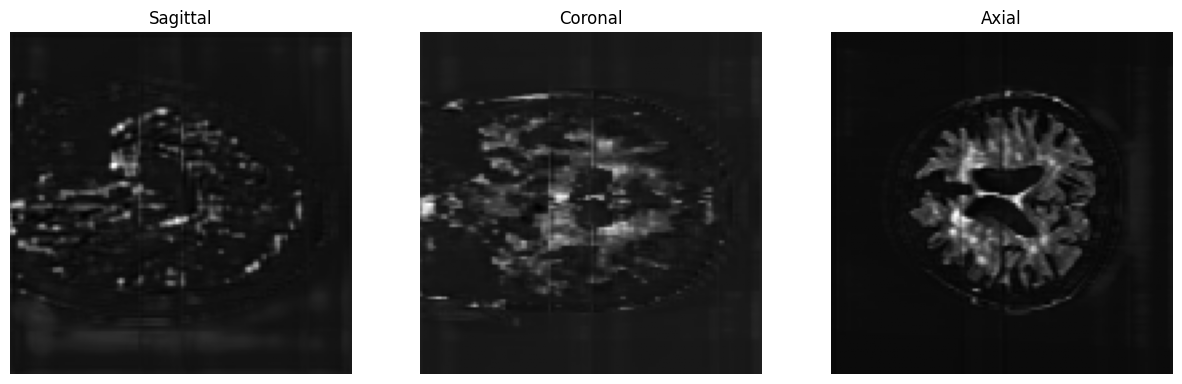

In [9]:
# visualize raw output
vis_slice(y_hat)

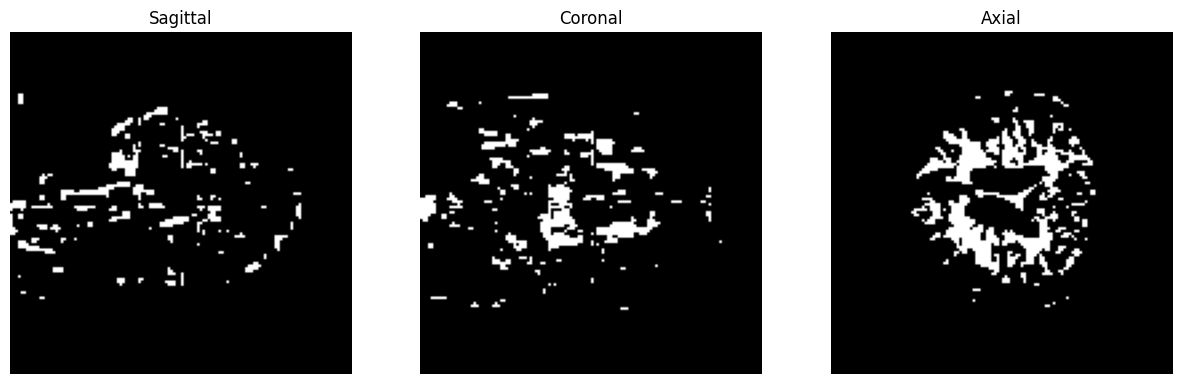

In [10]:
# visualize with threshold
vis_slice((y_hat > 0.5).int()) 

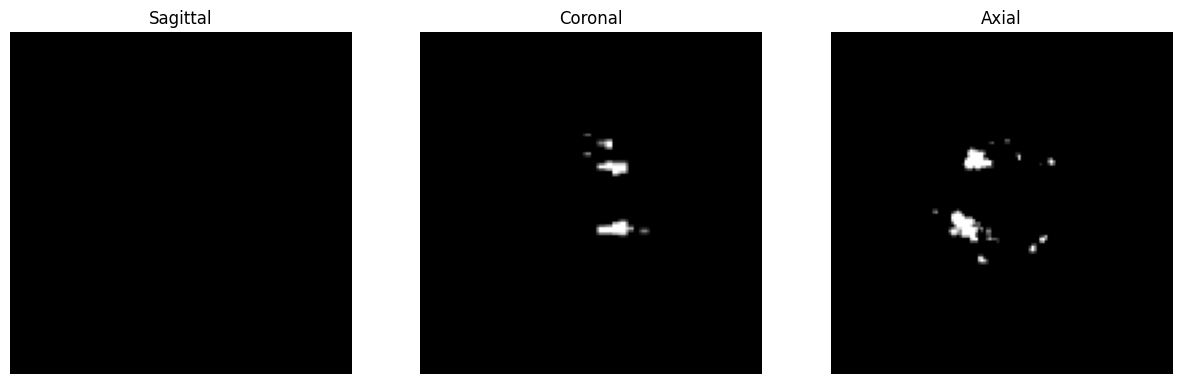

In [11]:
# visualize gold data
vis_slice_mask(batch["WMH"][0:1])